In [1]:
!pip install -U jax[cuda112] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jaxlib[cuda112] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install dm-haiku
!pip install tensorflow-probability
!pip install tensorflow-datasets
!pip install imbalanced-learn
!pip install -U git+https://github.com/Habush/Sklearn-genetic-opt.git
!pip install git+https://github.com/blackjax-devs/blackjax.git

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.21-py3-none-any.whl size=1263550 sha256=b7ed5c427e41174b6972143d216d60ffb97cb916b180c773b1b79fd18a428fc7
  Stored in directory: /root/.cache/pip/wheels/cd/fe/13/b51a21b340580b56f5378c5e68d14d19e74e956d575397c41f
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 MB 14.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.cudnn

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
# %cd /home/xabush/code/personal/nn_tutorial
import jax
import haiku as hk
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import blackjax
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from nn_util import *
from gibbs_sampler import *
plt.style.use('ggplot')
%load_ext autoreload

In [3]:
jax.default_backend()

'gpu'

In [4]:
seeds, data_dfs, net_dfs, feat_ls = load_bmm_files("./bmm_data_thr_5_F_8_f100")
seeds

[82, 91, 13, 92, 64, 10, 28, 55, 96, 97]

In [5]:
seed_idx = 7
seed, net, data = prepare_data(seeds, seed_idx, data_dfs, net_dfs, test_size=0.2)
print(f"seed: {seed}")
X_train, X_test, y_train, y_test = data
p = X_train.shape[1]
rng_key = jax.random.PRNGKey(seed)

(array([0., 1.]), array([133, 167]))
seed: 55


In [6]:
# from imblearn.under_sampling import RandomUnderSampler
#
# rus = RandomUnderSampler(random_state=seed)
# X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
# np.unique(y_train_res, return_counts=True)

In [7]:
X_train, X_test, y_train, y_test = jax.device_put(X_train), jax.device_put(X_test), \
                                    jax.device_put(y_train), jax.device_put(y_test)

### Baseline Logistic Regression

In [8]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [9]:
from sklearn.linear_model import LogisticRegression


log_param_grid = {"C":np.logspace(-2, 1, 10)}
log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=3, scoring="roc_auc", cv=cv).fit(X_train, y_train)
log_grid_cv.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ............................C=0.01;, score=0.689 total time=   0.7s
[CV 2/5] END ............................C=0.01;, score=0.578 total time=   0.0s
[CV 3/5] END ............................C=0.01;, score=0.727 total time=   0.0s
[CV 4/5] END ............................C=0.01;, score=0.571 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=0.608 total time=   0.0s
[CV 1/5] END ............C=0.021544346900318832;, score=0.692 total time=   0.0s
[CV 2/5] END ............C=0.021544346900318832;, score=0.580 total time=   0.0s
[CV 3/5] END ............C=0.021544346900318832;, score=0.727 total time=   0.0s
[CV 4/5] END ............C=0.021544346900318832;, score=0.561 total time=   0.0s
[CV 5/5] END ............C=0.021544346900318832;, score=0.605 total time=   0.0s
[CV 1/5] END ............C=0.046415888336127774;, score=0.713 total time=   0.0s
[CV 2/5] END ............C=0.046415888336127774;

{'C': 0.46415888336127775}

In [11]:
clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
cv_score = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train, y_train)
test_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print(f"cv score: {cv_score}, test_score: {test_score}")

cv score: 0.6444678778012112, test_score: 0.7059483456495408


### Grid Search Bayesian NN hyper parameters

In [53]:
gamma_params = np.logspace(-1, 1, 5)
gamma_params = np.insert(gamma_params, 0, 0.0)
temps = np.geomspace(1.0, 10, 5)
# init_lr = [1e-3, 1e-4, 1e-5, 1e-6]
# batch_sizes = np.linspace(50, 100, 6, dtype=np.int32)
# lr_schedules = ["constant", "cyclic"]

In [ ]:

%autoreload
from sgmcmc import MixedSGMCMC
from gibbs_sampler import *
from nn_util import *
param_grid = {"eta": gamma_params, "mu": gamma_params, "temp": temps}

grid_cv = GridSearchCV(estimator=MixedSGMCMC(seed=seed, sigma=1.0, lr_schedule="cyclical",n_samples=2000, n_chains=3,
                                             batch_size=20, disc_lr=5e-5, contin_lr=1e-5, layer_dims=[200]), param_grid=param_grid, cv=cv, verbose=1).fit(X_train, y_train, J=net, activation_fns=["tanh"])

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [ ]:
print(grid_cv.best_score_)
best_params = grid_cv.best_params_
print(best_params)

In [ ]:
import pickle
with open(f"./exp_data_4/bmm/grid_cv_seed_{seed}", "wb") as fp:
    pickle.dump(grid_cv.best_params_, fp)

In [25]:
# grid_cv.best_params_
%autoreload
from sgmcmc import MixedSGMCMC
best_params = {'eta': 0.1, 'lr_schedule': 'constant', 'mu': 0.1, 'sigma': 1.0}

In [11]:
net_abs = np.abs(net)
net_abs[net_abs > 0.] = 1.
net_abs

array([[0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.]])

In [47]:
%autoreload

from sgmcmc import MixedSGMCMC
eta, mu = 1.0, 1.0
sigma = 1.0
mixed_sgmcmc = MixedSGMCMC(seed=seed, lr_schedule="cyclical", n_samples=2000, n_chains=3, disc_lr=5e-5, contin_lr=1e-5,
                           batch_size=20, layer_dims=[200], cycle_len=20, eta=eta, mu=mu, sigma=sigma)
cv_score = cross_val_score(mixed_sgmcmc, X_train, y_train, cv=cv, fit_params={"J": net, "activation_fns": ["tanh"]})
print(np.mean(cv_score))
mixed_sgmcmc.fit(X_train, y_train, J=net, activation_fns=["tanh"])
mixed_sgmcmc.score(X_test, y_test)

0.6252031916329556


0.729517364245239

In [48]:
cv_score

array([0.70979023, 0.56437389, 0.68606701, 0.57495591, 0.59082892])

In [37]:
mixed_sgmcmc.states_.discrete_position.shape

(1500, 100)

In [39]:
k = mixed_sgmcmc.n_samples - mixed_sgmcmc.n_warmup
if mixed_sgmcmc.lr_schedule == "cyclical":
    j = k // mixed_sgmcmc.cycle_len

else:
    j = k

warmup_gamma_samples_1 = mixed_sgmcmc.warmup_states_.discrete_position.reshape(mixed_sgmcmc.n_chains, -1 , p)
warmup_param_samples_1 = jax.tree_util.tree_map(lambda x: x.reshape((mixed_sgmcmc.n_chains, mixed_sgmcmc.n_warmup) +  x.shape[1:]),  mixed_sgmcmc.warmup_states_.contin_position)
gamma_samples_1 = mixed_sgmcmc.states_.discrete_position.reshape(mixed_sgmcmc.n_chains, -1, p)
param_samples_1 = jax.tree_util.tree_map(lambda x: x.reshape((mixed_sgmcmc.n_chains, -1) +  x.shape[1:]),  mixed_sgmcmc.states_.contin_position)

In [38]:
mixed_sgmcmc.states_.contin_position["linear"]["w"].shape

(1500, 100, 200)

In [40]:
disc_log_prior = generate_disc_logprior_fn(net, mu, eta)
contin_log_prior = generate_contin_logprior_fn(sigma)


warmup_disc_logprobs = jax.vmap(jax.vmap(disc_log_prior))(warmup_gamma_samples_1)
final_disc_logprobs = jax.vmap(jax.vmap(disc_log_prior))(gamma_samples_1)

# disc_logprobs[c] = np.concatenate([warmup_disc_logprobs, final_disc_logprobs], axis=0)

warmup_contin_logprobs = jax.vmap(jax.vmap(contin_log_prior))(warmup_param_samples_1)
final_contin_logprobs = jax.vmap(jax.vmap(contin_log_prior))(param_samples_1)

disc_logprobs = jnp.concatenate([warmup_disc_logprobs, final_disc_logprobs], axis=-1)
contin_logprobs = jnp.concatenate([warmup_contin_logprobs, final_contin_logprobs], axis=-1)
# contin_logprobs[c] = np.concatenate([warmup_contin_logprobs, final_contin_logprobs], axis=0)


In [41]:
contin_logprobs.shape

(3, 1500)

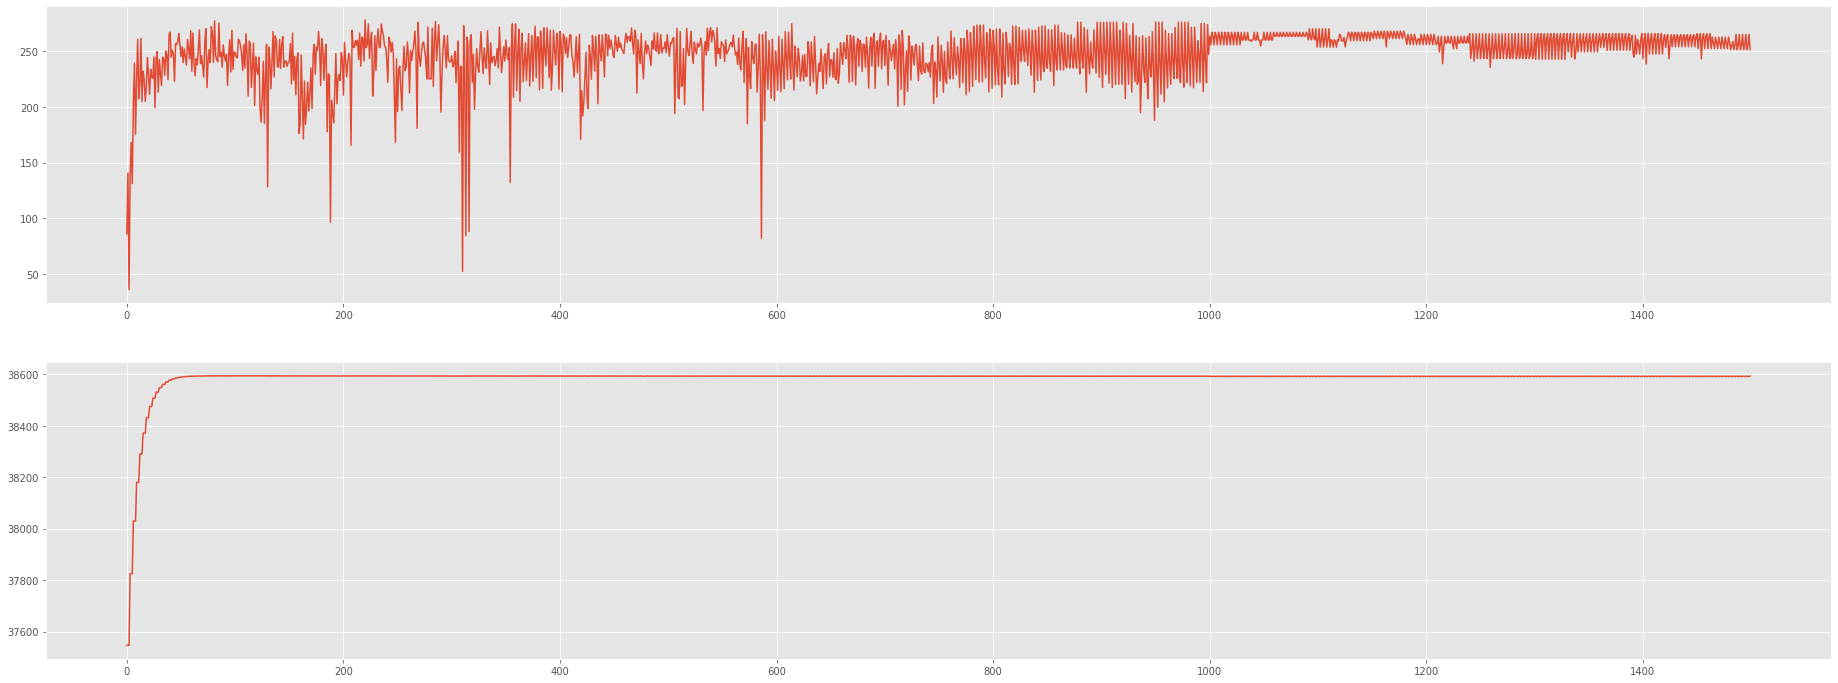

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(32, 12))

for i in range(1):
    ax1.plot(disc_logprobs[i])
    ax2.plot(contin_logprobs[i])

In [52]:
jnp.argwhere(jnp.mean(mixed_sgmcmc.states_.discrete_position, axis=0) == 1.0).ravel() + 1

DeviceArray([  1,   2,   4,   5,   7,   9,  11,  13,  14,  18,  20,  21,
              26,  27,  34,  40,  44,  45,  48,  50,  57,  59,  61,  63,
              66,  70,  74,  81,  91,  93,  96,  97,  98, 100],            dtype=int32)

In [51]:
jnp.mean(mixed_sgmcmc.states_.discrete_position, axis=0)

DeviceArray([1.0000000e+00, 1.0000000e+00, 9.6733332e-01, 1.0000000e+00,
             1.0000000e+00, 6.0000001e-03, 1.0000000e+00, 1.5333333e-02,
             1.0000000e+00, 9.9066663e-01, 1.0000000e+00, 9.3999997e-02,
             1.0000000e+00, 1.0000000e+00, 2.1200000e-01, 2.6199999e-01,
             4.5600000e-01, 1.0000000e+00, 9.5800000e-01, 1.0000000e+00,
             1.0000000e+00, 1.7999999e-02, 3.7666667e-01, 1.6666666e-02,
             4.3399999e-01, 1.0000000e+00, 1.0000000e+00, 3.4599999e-01,
             8.2666665e-01, 4.7200000e-01, 6.1999999e-02, 2.9333333e-02,
             1.4933333e-01, 1.0000000e+00, 1.2066667e-01, 3.3999998e-02,
             6.6666666e-04, 0.0000000e+00, 9.4533330e-01, 1.0000000e+00,
             5.5266666e-01, 1.9800000e-01, 0.0000000e+00, 1.0000000e+00,
             1.0000000e+00, 9.9333334e-01, 5.0733334e-01, 1.0000000e+00,
             0.0000000e+00, 1.0000000e+00, 9.9999998e-03, 3.9999997e-03,
             4.5333333e-02, 6.4866668e-01, 0.000000

In [49]:
#Slightly increase the temperature
mixed_sgmcmc_2 = MixedSGMCMC(seed=seed, lr_schedule="constant", n_samples=2000, n_chains=3, temp=1.0, disc_lr=5e-5, batch_size=20,
                           eta=1.0, mu=1.0, sigma=1.0, layer_dims=[200], cycle_len=5)
cv_score = cross_val_score(mixed_sgmcmc_2, X_train, y_train, cv=cv, fit_params={"J": net, "activation_fns": ["tanh"]})
print(np.mean(cv_score))
mixed_sgmcmc_2.fit(X_train, y_train, J=net, activation_fns=["tanh"])
mixed_sgmcmc_2.score(X_test, y_test)

0.6227587296585664


0.7059483487915801

In [65]:
gamma_samples_2 = mixed_sgmcmc_2.states_.discrete_position

np.allclose(gamma_samples_1, gamma_samples_2)

False

In [66]:
jnp.argwhere(jnp.mean(mixed_sgmcmc_2.states_.discrete_position, axis=0) > 0.7).ravel()

DeviceArray([ 0,  3,  5,  9, 10, 19, 23, 24, 26, 27, 28, 34, 35, 36, 37,
             38, 40, 43, 46, 47, 48, 49, 52, 53, 54, 57, 58, 60, 65, 66,
             68, 69, 70, 71, 75, 78, 82, 83, 84, 85, 94, 98], dtype=int32)

In [67]:
jnp.mean(gamma_samples_2, axis=0)

DeviceArray([0.73833334, 0.41      , 0.20166667, 1.        , 0.26833335,
             0.71000004, 0.14666668, 0.6383333 , 0.19500001, 0.7016667 ,
             0.845     , 0.21833333, 0.65333337, 0.11166667, 0.20333333,
             0.37666667, 0.68833333, 0.61333334, 0.38333336, 0.745     ,
             0.6566667 , 0.19      , 0.68      , 0.83833337, 1.        ,
             0.6333333 , 0.75333333, 0.71333337, 0.7166667 , 0.4116667 ,
             0.28666666, 0.125     , 0.675     , 0.08833334, 0.7916667 ,
             1.        , 0.73333335, 1.        , 1.        , 0.15666667,
             1.        , 0.685     , 0.64      , 0.77833337, 0.41500002,
             0.46666667, 0.7166667 , 0.7016667 , 0.74333334, 0.75666666,
             0.5366667 , 0.26833335, 1.        , 1.        , 1.        ,
             0.48833334, 0.69      , 0.7116667 , 0.74666667, 0.685     ,
             0.81666666, 0.26000002, 0.22333334, 0.51666665, 0.67833334,
             0.84000003, 1.        , 0.41      , 0.

In [9]:
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn_genetic import GASearchCV
gamma_params = Continuous(0, 10., distribution="uniform")
sigmas = Continuous(0., 10, distribution="uniform")
temps = Continuous(0., 10, distribution="uniform")
param_grid = {"eta": gamma_params, "mu": gamma_params, "temp": temps,
              "sigma": sigmas}

In [10]:
%autoreload
from sgmcmc import MixedSGMCMC
from sklearn_genetic.callbacks import ProgressBar
from sklearn_genetic.callbacks import DeltaThreshold, TimerStopping
delta_callback = DeltaThreshold(threshold=0.001, generations=1, metric='fitness')
timer_callback = TimerStopping(total_seconds=3600)
progres_callback = ProgressBar()
mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=2000, n_chains=3, disc_lr=5e-5, layer_dims=[200],
                           lr_schedule="cyclical", batch_size=20, cycle_len=20)
evolved_grid_cv = GASearchCV(estimator=mixed_sgmcmc, cv=cv,
                             param_grid=param_grid, verbose=True, population_size=30, generations=1).fit(X_train, y_train, callbacks=[progres_callback, delta_callback, timer_callback],
                               J=net, activation_fns=["tanh"])

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:3326: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	0.624181	0.0165976  	0.66147    	0.56573    
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


In [21]:
evolved_grid_cv.best_score_

0.6614700166868516

In [39]:
evolved_grid_cv.best_params_

{'eta': 0.5400128315507968,
 'mu': 8.20326355553801,
 'temp': 0.8786816336151093,
 'sigma': 2.944415742614189}

In [ ]:
best_params = {'eta': 0.5400128315507968,
 'mu': 8.20326355553801,
 'temp': 0.8786816336151093,
 'sigma': 2.944415742614189}

In [22]:
mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=2000, n_chains=3, disc_lr=5e-5, layer_dims=[200],
                           lr_schedule="cyclical", batch_size=20, cycle_len=20, **evolved_grid_cv.best_params_)
cv_score = cross_val_score(mixed_sgmcmc, X_train, y_train, cv=cv, fit_params={"J": net, "activation_fns": ["tanh"]})
print(np.mean(cv_score))
mixed_sgmcmc.fit(X_train, y_train, J=net, activation_fns=["tanh"])
mixed_sgmcmc.score(X_test, y_test)

0.6614700166868516


0.7048260194116718

In [28]:
cv_score

array([0.74650351, 0.61904762, 0.64726632, 0.57142857, 0.72310406])

In [47]:
gamma_idx = jnp.argwhere(jnp.mean(mixed_sgmcmc.states_.discrete_position, axis=0) > 0.01).ravel() + 1
gamma_idx

DeviceArray([  1,   2,   3,   4,   8,  10,  11,  15,  17,  19,  21,  25,
              27,  34,  41,  48,  54,  58,  59,  65,  66,  67,  69,  73,
              75,  78,  80,  84,  86,  88,  92,  93,  96,  98, 100],            dtype=int32)

In [46]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=10000, C=0.01)
cv_score = np.mean(cross_val_score(clf, X_train[:,gamma_idx], y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train[:,gamma_idx], y_train)
test_score = roc_auc_score(y_test, clf.predict_proba(X_test[:,gamma_idx])[:,1])
print(f"cv score: {cv_score}, test_score: {test_score}")

cv score: 0.51995411995412, test_score: 0.381593691695203
